<a href="https://colab.research.google.com/github/zj71/Computer-Vision/blob/main/CV_Lab_Session_5_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Overview
Welcome to todays lab session. In this lab we will see how to create image panoramas by calculating keypoints in each image, describing those keypoints, and then matching the best matching points and transforming the images to stitch them together.

This lab session will all be done by filling in the blanks in this Google Colab sheet. You'll need a google account to continue, but it's pretty straightforward to sign up if you don't have one already. 
The best thing to do would be to save a copy of this notebook in your personal google drive and edit it from there.

**Top Tips**
+ Check the documentation and links for help!
+ Remember assignment in Python is by reference! If you want to make a copy of a numpy object use [np.copy](https://numpy.org/doc/stable/reference/generated/numpy.copy.html) to do a [deepcopy](https://docs.python.org/3/library/copy.html).
+ Calling [plt.show](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.show.html) shows whatever you've been trying to visualise this far as a single figure. If you want multiple axis on a single figure you can use [subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html)

# Preparation
You need to call the code in the cell below to downgrade OpenCV to the correct version for this assignment! this is because we want to use SIFT features, and they are not available in the newer versions. If you're using your own version of python, and don't want to reinstall OpenCV, try another set of feature detectors/descriptors such as [ORB](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html)

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 92kB/s 
     |████████████████████████████████| 20.2MB 103kB/s 
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninsta

# Getting Data
We are going to download some example images to work with, but you can upload your own images by following the colaboratory [guidance](https://colab.research.google.com/notebooks/io.ipynb). Personally, I think the easiest way to do it is to use the files menu on the side of the screen.

This week I've uploaded 3 photos that I've taken of the library for you to play with.
**Also, for this lab make sure you resize your images so they're not too big** This is because we would need to define some quite different parameters for the filters for them to work well.

In [ ]:
!wget "http://users.sussex.ac.uk/~is321/lib_center.jpg" -O lib_center.jpg
!wget "http://users.sussex.ac.uk/~is321/lib_left.jpg" -O lib_left.jpg
!wget "http://users.sussex.ac.uk/~is321/lib_right.jpg" -O lib_right.jpg

--2020-03-04 10:01:40--  http://users.sussex.ac.uk/~is321/lib_center.jpg
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650057 (1.6M) [image/jpeg]
Saving to: ‘lib_center.jpg’

lib_center.jpg      100%[===================>]   1.57M   440KB/s    in 3.7s    

2020-03-04 10:01:44 (440 KB/s) - ‘lib_center.jpg’ saved [1650057/1650057]

--2020-03-04 10:01:45--  http://users.sussex.ac.uk/~is321/lib_left.jpg
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2283331 (2.2M) [image/jpeg]
Saving to: ‘lib_left.jpg’

lib_left.jpg        100%[===================>]   2.18M   584KB/s    in 3.8s    

2020-03-04 10:01:49 (584 KB/s) - ‘lib_left.jpg’ saved [2283331/2283331]

--2020-03-04 1

# Common Packages and Image Reading
As we've seen before there are some common packages that we might want to load. We should also convert any images we load to RGB from BGR.

**Also, for this lab make sure you resize your images so they're not too big** This is because we would need to define some quite different parameters for the filters for them to work well.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np

# Inserted some magic code to make the figures slightly larger, these numbers can be tweaked
plt.rcParams['figure.figsize'] = [10, 5]

lib_center = cv2.imread('./lib_center.jpg')
lib_center = cv2.cvtColor(lib_center, cv2.COLOR_BGR2RGB)

lib_left = cv2.imread('./lib_left.jpg')
lib_left = cv2.cvtColor(lib_left, cv2.COLOR_BGR2RGB)

lib_right = cv2.imread('./lib_right.jpg')
lib_right = cv2.cvtColor(lib_right, cv2.COLOR_BGR2RGB)

# Resize the images so that they're not too big!
lib_left = cv2.resize(lib_left, (lib_left.shape[1] // 6, lib_left.shape[0] // 6), interpolation=cv2.INTER_AREA)
lib_right = cv2.resize(lib_right, (lib_right.shape[1] // 6, lib_right.shape[0] // 6), interpolation=cv2.INTER_AREA)
lib_center = cv2.resize(lib_center, (lib_center.shape[1] // 6, lib_center.shape[0] // 6), interpolation=cv2.INTER_AREA)

# Detecting and describing keypoints
In this section we'll look at how to find interest points or keypoints in each of the images, and then calculate a description of those points. Please take a look at the [documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html#sift-intro)


1. Start by preparing your images, they need to be grayscale and in uint8 format.
2. Create a SIFT object and detect keypoints and compute their descriptors
3. Draw the keypoints on the image

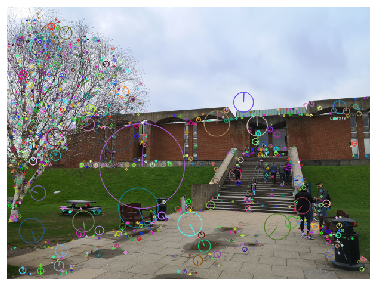

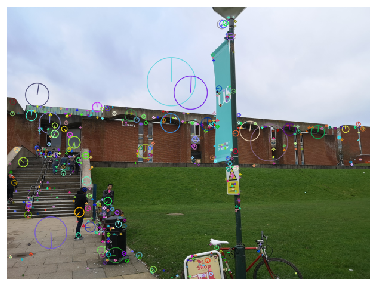

In [ ]:

# Keypoints and descriptors are calculated on the grayscale images, so 
# make sure you convert your images to grayscale using np.mean(..., axis=-1) or
# whatever your favourite approach is.
# Make sure the grayscale image arrays are cast to np.uint8(img) for OpenCV
gray_center = np.uint8(np.mean(lib_center, axis=-1))
gray_left = np.uint8(np.mean(lib_left, axis=-1))
gray_right = np.uint8(np.mean(lib_right, axis=-1))

# Let's start by creating a SIFT object, have a look at the docs to see
# what function to call
sift = cv2.xfeatures2d.SIFT_create()
# Using the SIFT object, detect keypoints and compute their descriptors
# The follow code presumes the keypoints are called kp_l and kp_r for the left
# and right images and the descriptors are called des_l and des_r
kp_c, des_c = sift.detectAndCompute(gray_center,None)
kp_l, des_l = sift.detectAndCompute(gray_left,None)
kp_r, des_r = sift.detectAndCompute(gray_right,None)


# This function will draw the keypoints on the images, showing their orientation
def draw_im_kps(img, kps):
  # Test that we passed a colour image into this function
  assert(img.shape[-1] == 3)
  img_kp = np.zeros_like(img)
  # Note that drawKeypoints overwrites the third argument! that's why I create
  # an empty array of the right size. 
  # Also note the flags option controls what information to draw, 4 indicates 
  # the size and orientation of the keypoints
  cv2.drawKeypoints(img, kps, img_kp, flags=4)
  plt.imshow(img_kp)
  plt.axis('off')
  plt.show()

# Pass the colour images and keypoints into the draw_im_kps function
draw_im_kps(lib_left, kp_l)
draw_im_kps(lib_right, kp_r)



# Matching keypoints
Once we've calculated these keypoints and described them, we need to try and find matching points between the two images. Take a look at the OpenCV [documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 
1. Let's start by creating a brute force matcher object (BFMatcher). There's an option for crossChecking, remind yourself what this is and consider if you want it.
2. Use the matcher to match the descriptors! I've provided a function to sort them by distance. Draw the matches and try and visually evaluate a good number of keypoints that match well.




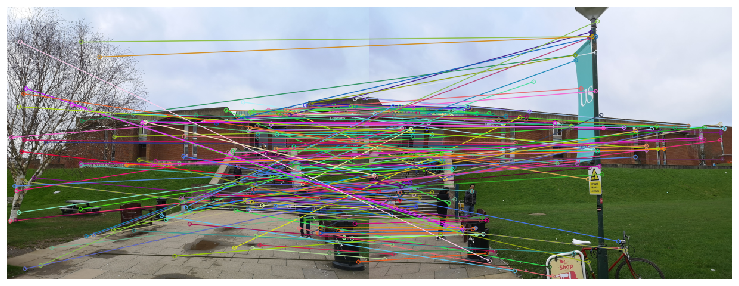

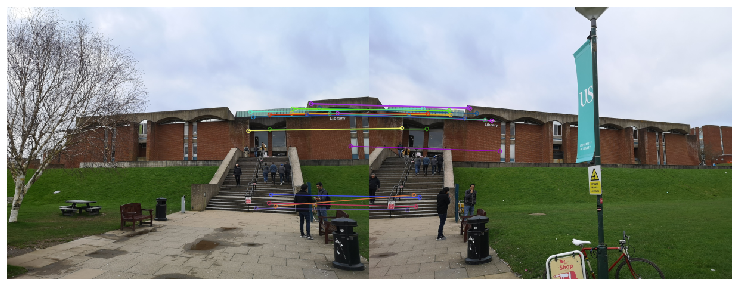

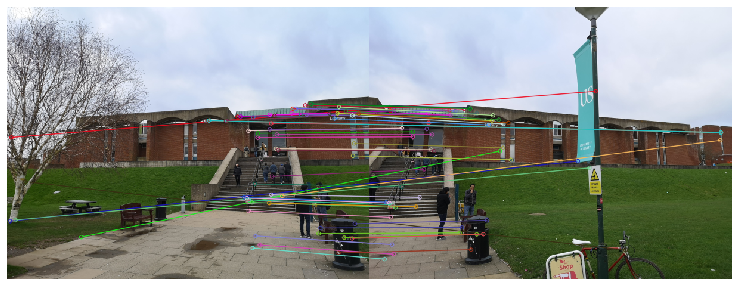

In [ ]:
# create BFMatcher object (it's in the cv2 namespace)
# make sure you chose the right distance metric for your descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors.
matches = bf.match(des_l,des_r)

# Sort them in the order of their the discriptor distance
matches = sorted(matches, key = lambda x:x.distance)

# This function draws the key point matches between images
def draw_kp_matches(_matches):
  # Draw first 10 matches.
  img3 = cv2.drawMatches(lib_left,kp_l,lib_right,kp_r,_matches,outImg=gray_left, flags=2)

  # Inserted some magic code to make the figures slightly larger, these numbers can be tweaked
  plt.rcParams['figure.figsize'] = [40, 5]
  plt.imshow(img3)
  plt.axis('off')
  plt.show()


# Draw the first 200 matches
draw_kp_matches(matches[:200])

# Try drawing fewer matches, until you find a good number that seem to mostly match

# Create a new list of only the good matches
good_matches = matches[:200]

good_matches = matches[:20]

draw_kp_matches(good_matches)

# For the solutions, I'll also include the k-nearest matches for visual comparison
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
knn_matches = flann.knnMatch(des_l,des_r,k=2)
# This matcher uses a different metric for choosing good keypoints, rather
# than choosing those with the minimum descriptor difference, it finds the
# nearest K=2 descriptors, and chooses matches where the nearest descriptor is 
# substnaitally closer than the 2nd nearest descriptor. This is a measure of 
# how unique the keypoint match is.
good_knn_matches = []
for m,n in knn_matches:
    if m.distance < 0.7*n.distance:
      good_knn_matches.append(m)
draw_kp_matches(good_knn_matches)

  




# Estimating the transformation between images and stitching
Now we've estimate the locations of keypoints, and matched them between the images, we can estimate a transformation to put these two images in the same coordinate system! In this case, we're going to put the right image into the coordinate system of the left image. 

For this section, I provide most of the code, the most important thing to look at is the arguments to cv2.findHomography
Do take a look at some of the [documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html) for more information about estimating homographies.

1. look at is the arguments to cv2.findHomography, particularly the 3rd argument (for RANSAC). Try setting it to 0
2. Read the rest of the code, and try and understand what it does.


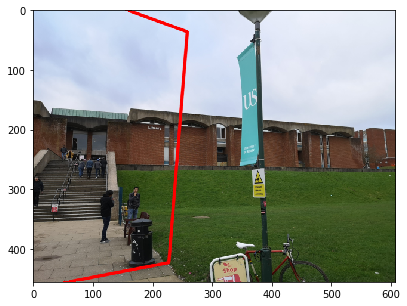

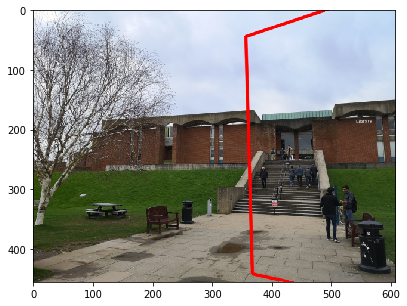

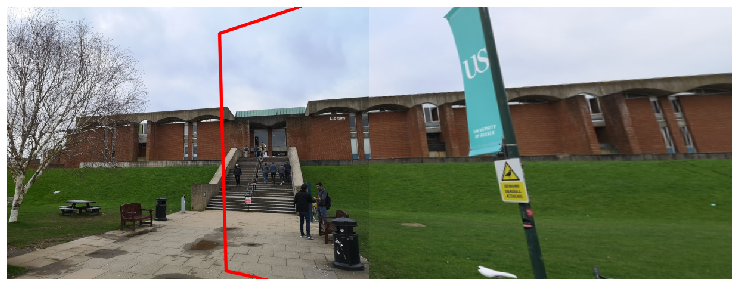

In [ ]:
# Extract the x,y coordinate location of the well matched points
# Note we shape it into a list of shape (no_points, 1, 2). The -1 is a wildcard.
src_pts = np.float32([ kp_l[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_r[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

#M, mask = cv2.findHomography(src_pts, dst_pts,0)
# Given the set of corresponding points between 2 images, estimate a perspective
# transformation (homography) to put all the src_pts in the coordinate system
# of dst_points
M, mask = cv2.findHomography(src_pts, dst_pts,cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# To visualise the transformation, let's calculate the corners of the image
h,w = gray_left.shape
corner_pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
# Let's warp the corner points into being in the destination image space (right image)
dst = cv2.perspectiveTransform(corner_pts,M)
# Let's mke a copy of the right image
lib_right_plt = np.copy(lib_right)
# and draw some lines to represent the left image geometry
cv2.polylines(lib_right_plt,[np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.imshow(lib_right_plt)
plt.show()


h,w = gray_right.shape
corner_pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
# Same as before, but this time we're putting the right image corners into
# the left image. This means we take the inverse of the homography transformation!
dst = cv2.perspectiveTransform(corner_pts, np.linalg.inv(M))
lib_right_plt = np.copy(lib_left)
cv2.polylines(lib_right_plt,[np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.imshow(lib_right_plt)
plt.show()

# Finally, to do the stitching, Let's paste a warped version of the right image,
# into the coordinate system of the left image. Note that we're making a new image
# that is the width both images.
result = cv2.warpPerspective(lib_right, np.linalg.inv(M), (lib_left.shape[1] + lib_right.shape[1], lib_left.shape[0]))
# Overwrite the left-hand side of the image with the original left image
result[0:lib_left.shape[0], 0:lib_left.shape[1]] = lib_left
# Draw some lines to illustrate the transform.
cv2.polylines(result,[np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.axis('off')
plt.imshow(result)
plt.show()

# Extensions
You don't have to do these, but if you complete the lab and want to learn more then give these a go! You also don't need to do them in any particular order.

+ At the beginning of the task, we resized the images to avoid calculating too many image keypoints. Once we've calculated and described the keypoints, we could transform these to being in the geometry of the original higher resolution image. Have a go at doing this, and draw the stitched images using the highest resolution images.
+ How resilient is this process to image noise? Try adding random noise to the images before calculating the keypoints/descriptors. How much does the final transfomation differ?
+ Try using different types of keypoint detectors/descriptors and observe the change in the resulting points, matches and transformations.
+ When using my data (and probably yours) the colour balance has changed between the two images. Think about we could fix this, and let me know what you come up with!
+ The final stitching is the geometry of the left image, how could we make it in the geometry of the right image? or the geometry between the two?




In [ ]:
#!/usr/bin/python
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

path = "1.jpg"

# your images in an array
imgs = loadImages(path)

for img in imgs:
    # you can show every image
    img.show()

FileNotFoundError: ignored

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('eiffel_2.jpeg')  
img2 = cv2.imread('eiffel_1.jpg') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

error: ignored